In [0]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

replicating local resources


In [0]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
import numpy as np
tf.__version__

setting tensorflow version in colab
TensorFlow 2.x selected.


'2.1.0'

# Word embeddings

We will setup a **SUPERVISED LEARNING** task to learn the **embeddings that best fit** our task. 

We have a very small example **labelled** dataset of sentences.

This notebook has been adapted from [this tutorial](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/).

See also [this tutorial](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526) for a larger example.

In [0]:
# define documents
docs = ['well done!',
		'good work',
		'great effort',
		'nice work',
		'excellent!',
		'weak',
		'poor effort!',
		'not good',
		'poor work',
		'could have done better.']
# define class labels
labels = np.array([1,1,1,1,1,0,0,0,0,0])

observe how Keras [`one_hot`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/one_hot) associates an integer with each word following an efficient hash function.

In [0]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)

[[39, 26], [31, 14], [24, 46], [9, 14], [36], [21], [26, 46], [39, 31], [26, 14], [1, 14, 26, 46]]


we **pad** the documents so that they all have the same length. See the [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function.

In [0]:
from keras.preprocessing.sequence import pad_sequences
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[39 26  0  0]
 [31 14  0  0]
 [24 46  0  0]
 [ 9 14  0  0]
 [36  0  0  0]
 [21  0  0  0]
 [26 46  0  0]
 [39 31  0  0]
 [26 14  0  0]
 [ 1 14 26 46]]


Using TensorFlow backend.


We **LINK** the embeddings layer to a supervised learning task

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
model = Sequential()
embedding_layer = Embedding(vocab_size, 4, input_length=max_length) 
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 4)              200       
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________
None


observe that embeddings are random before training

In [0]:
words = ["good", "great", "better", "excellent", "nice", "well", "poor", "weak", "not", "done", "work", "could", "effort", "have"]

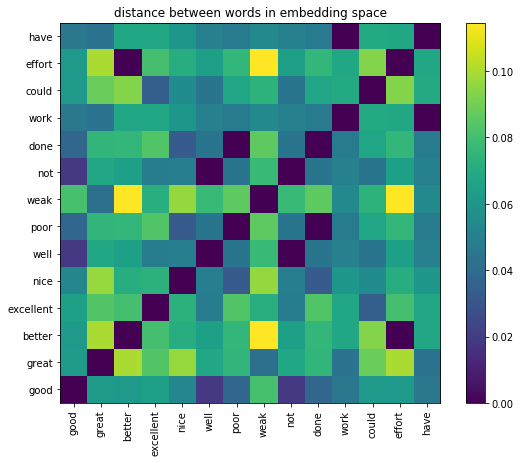

In [0]:
def plot_distance_matrix():
  import numpy as np
  import matplotlib.pyplot as plt
  %matplotlib inline
  import itertools
  embs = {i:embedding_layer(np.r_[one_hot(i, vocab_size)]).numpy()[0] for i in words}
  
  distances = np.zeros((len(words), len(words)))

  for i,j in itertools.product(range(len(words)), range(len(words))):
    distances[i,j] = np.linalg.norm(embs[words[i]]-embs[words[j]])

  plt.figure(figsize=(9,7))
  plt.imshow(distances, origin="bottom", cmap=plt.cm.viridis)
  plt.colorbar()
  plt.xticks(range(len(words)), words, rotation="vertical")
  plt.yticks(range(len(words)), words);
  plt.title("distance between words in embedding space")

plot_distance_matrix()

In [0]:
# fit the model
model.fit(padded_docs, labels, epochs=200, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 100.000000


these are the embeddings learnt for each word

In [0]:
embs = {i:embedding_layer(np.r_[one_hot(i, vocab_size)]).numpy()[0] for i in words}
embs

{'better': array([ 0.15662113, -0.20677087, -0.22002105,  0.19381356], dtype=float32),
 'could': array([-0.17400135, -0.18697308,  0.2757997 , -0.18574217], dtype=float32),
 'done': array([-0.21300021, -0.20823544,  0.24230193, -0.28707692], dtype=float32),
 'effort': array([ 0.15662113, -0.20677087, -0.22002105,  0.19381356], dtype=float32),
 'excellent': array([ 0.21884094,  0.23656884, -0.2175134 ,  0.25209367], dtype=float32),
 'good': array([ 0.264647  ,  0.21860768, -0.21636377, -0.01202946], dtype=float32),
 'great': array([ 0.24817602,  0.22866288, -0.28726876,  0.22425152], dtype=float32),
 'have': array([ 0.08130752, -0.10252355,  0.09506772,  0.08928391], dtype=float32),
 'nice': array([ 0.19211377,  0.2708843 , -0.22646762,  0.19018017], dtype=float32),
 'not': array([ 0.01903311, -0.00437009,  0.04380124, -0.01163221], dtype=float32),
 'poor': array([-0.21300021, -0.20823544,  0.24230193, -0.28707692], dtype=float32),
 'weak': array([-0.16300204, -0.20586708,  0.22321883, 

and the distance matrix for each word, Observe words with similar meaning have small distances.

Why is the word **better** not related to other words with positive meaning?. Look at the documents in the training set.

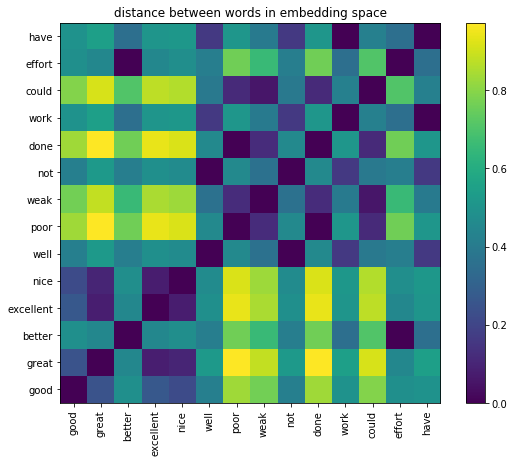

In [0]:
plot_distance_matrix()

observe also the weights of the embedding layer

In [0]:
embedding_layer.get_weights()

[array([[-0.20376495,  0.23360622,  0.14798218,  0.01557513],
        [-0.17400135, -0.18697308,  0.2757997 , -0.18574217],
        [-0.00667449, -0.01887449,  0.02074851, -0.002654  ],
        [ 0.00064733,  0.03650383,  0.01492504,  0.01617446],
        [-0.0460006 ,  0.00648385, -0.01088699,  0.01803375],
        [-0.00697448,  0.02913299,  0.04774039, -0.00434145],
        [ 0.0413821 , -0.01520252,  0.02239725,  0.04641582],
        [ 0.01532091, -0.03085705, -0.00660632,  0.03710078],
        [-0.02462497, -0.04097638, -0.02815908, -0.00116553],
        [ 0.19211377,  0.2708843 , -0.22646762,  0.19018017],
        [-0.01577454,  0.04706867,  0.04602503,  0.01194163],
        [ 0.047678  ,  0.0329445 , -0.04797627, -0.02119712],
        [-0.01616488,  0.01169489, -0.02517186, -0.028073  ],
        [-0.02591636, -0.02124904,  0.00774839, -0.01508287],
        [ 0.08130752, -0.10252355,  0.09506772,  0.08928391],
        [ 0.01708115,  0.00728705,  0.02838297,  0.03486216],
        

## embeddings are useful for **sparse data** (for instance, large one_hot encodings)

## you can use existing embeddings as starting point of your training: **transfer learning**

# A larger example with IMDB

### Movie reviews with labels (positive or negative)

In [0]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
max_features = 5000
maxlen = 500


### Observe IMDB data is already one hot encoded with a premade dictionary

- `max_features`: the dictionary size
- `max_len`: the maximum number of words per review

In [0]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) 
for i in range(10):
    print (i, len(x_train[i]), y_train[i], x_train[i][:20])

0 218 1 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
1 189 0 [1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 4369, 2, 134, 26, 4, 715, 8, 118, 1634, 14]
2 141 0 [1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 2, 54, 61, 369, 13, 71, 149, 14]
3 550 1 [1, 4, 2, 2, 33, 2804, 4, 2040, 432, 111, 153, 103, 4, 1494, 13, 70, 131, 67, 11, 61]
4 147 0 [1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401, 18, 457, 88, 13, 2626]
5 43 0 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139]
6 123 1 [1, 2, 365, 1234, 5, 1156, 354, 11, 14, 2, 2, 7, 1016, 2, 2, 356, 44, 4, 1349, 500]
7 562 0 [1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2]
8 233 1 [1, 43, 188, 46, 5, 566, 264, 51, 6, 530, 664, 14, 9, 1713, 81, 25, 1135, 46, 7, 6]
9 130 0 [1, 14, 20, 47, 111, 439, 3445, 19, 12, 15, 166, 12, 216, 125, 40, 6, 364, 352, 707, 1187]


### We could also inspect the dictionary and actual words in some reviews

In [0]:
wi = imdb.get_word_index()
iw = {v:k for k,v in wi.items()}
for i in range(5):
    print (i, [iw[j] for j in x_train[i][:20]])

0 ['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have']
1 ['the', 'thought', 'solid', 'thought', 'and', 'do', 'making', 'to', 'is', 'spot', 'nomination', 'and', 'while', 'he', 'of', 'jack', 'in', 'where', 'picked', 'as']
2 ['the', 'as', 'there', 'in', 'at', 'by', 'br', 'of', 'sure', 'many', 'br', 'of', 'and', 'no', 'only', 'women', 'was', 'than', "doesn't", 'as']
3 ['the', 'of', 'and', 'and', 'they', 'halfway', 'of', 'identity', 'went', 'plot', 'actors', 'watch', 'of', 'share', 'was', 'well', 'these', 'can', 'this', 'only']
4 ['the', 'sure', 'themes', 'br', 'only', 'acting', 'i', 'i', 'was', 'favourite', 'as', 'on', 'she', 'they', 'hat', 'but', 'already', 'most', 'was', 'scares']


### Pad reviews so that all of them have the same length


In [0]:
from tensorflow.keras import preprocessing
xx_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
xx_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [0]:
xx_train.shape

(25000, 500)

In [0]:
print (x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [0]:
xx_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Create a simple model

In [0]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
model = Sequential()
embedding_layer = Embedding(max_features, 32, input_length=maxlen)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(xx_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 316us/sample - loss: 0.4656 - accuracy: 0.7428 - val_loss: 0.3079 - val_accuracy: 0.8670
Epoch 2/10
20000/20000 [==============================] - 6s 288us/sample - loss: 0.1576 - accuracy: 0.9413 - val_loss: 0.3513 - val_accuracy: 0.8614
Epoch 3/10
20000/20000 [==============================] - 6s 283us/sample - loss: 0.0296 - accuracy: 0.9920 - val_loss: 0.5231 - val_accuracy: 0.8582
Epoch 4/10
20000/20000 [==============================] - 6s 289us/sample - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.6693 - val_accuracy: 0.8632
Epoch 5/10
20000/20000 [==============================] - 6s 298us/sample - loss: 3.9839e-04 - accuracy: 1.0000 - val_loss: 0.7206 - val_accuracy: 0.8664
Epoch 6/10
20000/20000 [==============================] - 6s 295us/sample - loss: 1.2997e-04 - accuracy: 1.0000 - val_loss: 0.7692 - val_accuracy: 0.8652
Epoch 7/10
20000/20000 [===================

### And we could even try a 1D convolutional layer on the sequence

In [0]:
# create the model
model = Sequential()
embedding_layer = Embedding(max_features, 8, input_length=maxlen)

model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 8)            40000     
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           800       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 250)               2000250   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 251       
Total params: 2,041,301
Trainable params: 2,041,301
Non-trainable params: 0
____________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(xx_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 10s 479us/sample - loss: 0.4164 - acc: 0.7915 - val_loss: 0.3195 - val_acc: 0.8638
Epoch 2/10
20000/20000 [==============================] - 4s 216us/sample - loss: 0.2387 - acc: 0.9054 - val_loss: 0.2665 - val_acc: 0.8928
Epoch 3/10
20000/20000 [==============================] - 4s 219us/sample - loss: 0.1909 - acc: 0.9278 - val_loss: 0.3000 - val_acc: 0.8810
Epoch 4/10
20000/20000 [==============================] - 4s 214us/sample - loss: 0.1616 - acc: 0.9385 - val_loss: 0.3005 - val_acc: 0.8932
Epoch 5/10
20000/20000 [==============================] - 4s 213us/sample - loss: 0.1339 - acc: 0.9511 - val_loss: 0.3036 - val_acc: 0.8928
Epoch 6/10
20000/20000 [==============================] - 4s 220us/sample - loss: 0.1073 - acc: 0.9614 - val_loss: 0.3689 - val_acc: 0.8896
Epoch 7/10
20000/20000 [==============================] - 4s 213us/sample - loss: 0.0814 - acc: 0.9701 - val_l